In [1]:
import pickle
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

In [9]:
def read_results(result_path):
    with open(result_path, 'rb') as file:
        results = pickle.load(file)
    return results

In [3]:
# result_path = '../../projects/benchmark/results'
# algo = 'STAMP'
# runtime = 'jitopt'
# device = 'cuda'
# datasource = 'rsc15'
# C = 1000
# filename = f'{algo}_{runtime}_{device}_{datasource}_C{C}_t50_results.pickle'
# r = read_results(os.path.join(result_path, filename))
# # for filename in os.listdir(result_path):
# #     if 'CORE' in filename and 'bolcom' in filename and 'C10000000_' in filename:
# #         f = os.path.join(result_path, filename)
# #         # checking if it is a file
# #         if os.path.isfile(f):
# #             print(f)
# #             r = read_results(f)
# #             break
# latency_df = r['latency_df']
# filtered_df = latency_df[latency_df['DateTime'] >= (latency_df['DateTime'].min() + pd.Timedelta(seconds=5))]
# filtered_df
# print(r)
# print(latency_df['DateTime'].min())
# print(latency_df['DateTime'].max())
# plt.scatter(filtered_df['DateTime'], filtered_df['LatencyInMs'])
# plt.show()

In [10]:
def get_results(modelname, runtime, device, datasource):
    result_path = '../../projects/benchmark/results'
    result = {}
    for C in [1000, 10000, 100000, 1000000, 10000000]:
        filename = f'{modelname}_{runtime}_{device}_{datasource}_C{C}_t50_results.pickle'
        f = os.path.join(result_path, filename)
        if os.path.isfile(f):
            r = read_results(f)
            result[C] = r['latency_df']
    return result

In [11]:
# # for model_name in ['core', 'gcsan', 'gru4rec', 'lightsans', 'narm', 'repeatnet', 'sasrec', 'sine', 'srgnn',
# #                        'stamp']:
# model_name='lightsans'
# runtime = 'jitopt'
# device = 'cuda'
# datasource = 'bolcom'
# results = get_results(model_name, runtime, device, datasource)
# fig, ax = plt.subplots(figsize=(16, 12))
# for C, latency_df in results.items():
#     filtered_df = latency_df[latency_df['DateTime'] >= (latency_df['DateTime'].min() + pd.Timedelta(seconds=5))]
#     # add 1 ms for log transformation
#     # filtered_df['LatencyInMs'] = filtered_df['LatencyInMs'] + 1
#     # sns.kdeplot(data = filtered_df['LatencyInMs'], cumulative = True, label = f'{C}', log_scale=False, ax=ax)
#     sns.ecdfplot(data=filtered_df['LatencyInMs'], complementary=False, label=f'{C}', log_scale=False, ax=ax)
# plt.title(f'Inference latency for {model_name} using {runtime} on {device}')
# # Get the matplotlib axis object
# ax = plt.gca()
# # Set the x-axis limits
# # ax.set_xlim([0, 20])
# # plt.axvline(x = 50, label = '50ms threshold')
# ax.legend()
# # plt.yscale('log')
# plt.legend(title='Unique items in catalog')
# plt.tight_layout()
# plt.xlabel('Inference latency (ms)')
# plt.savefig(f'{model_name}_{runtime}_{device}_{datasource}.pdf', bbox_inches='tight')
# plt.show()

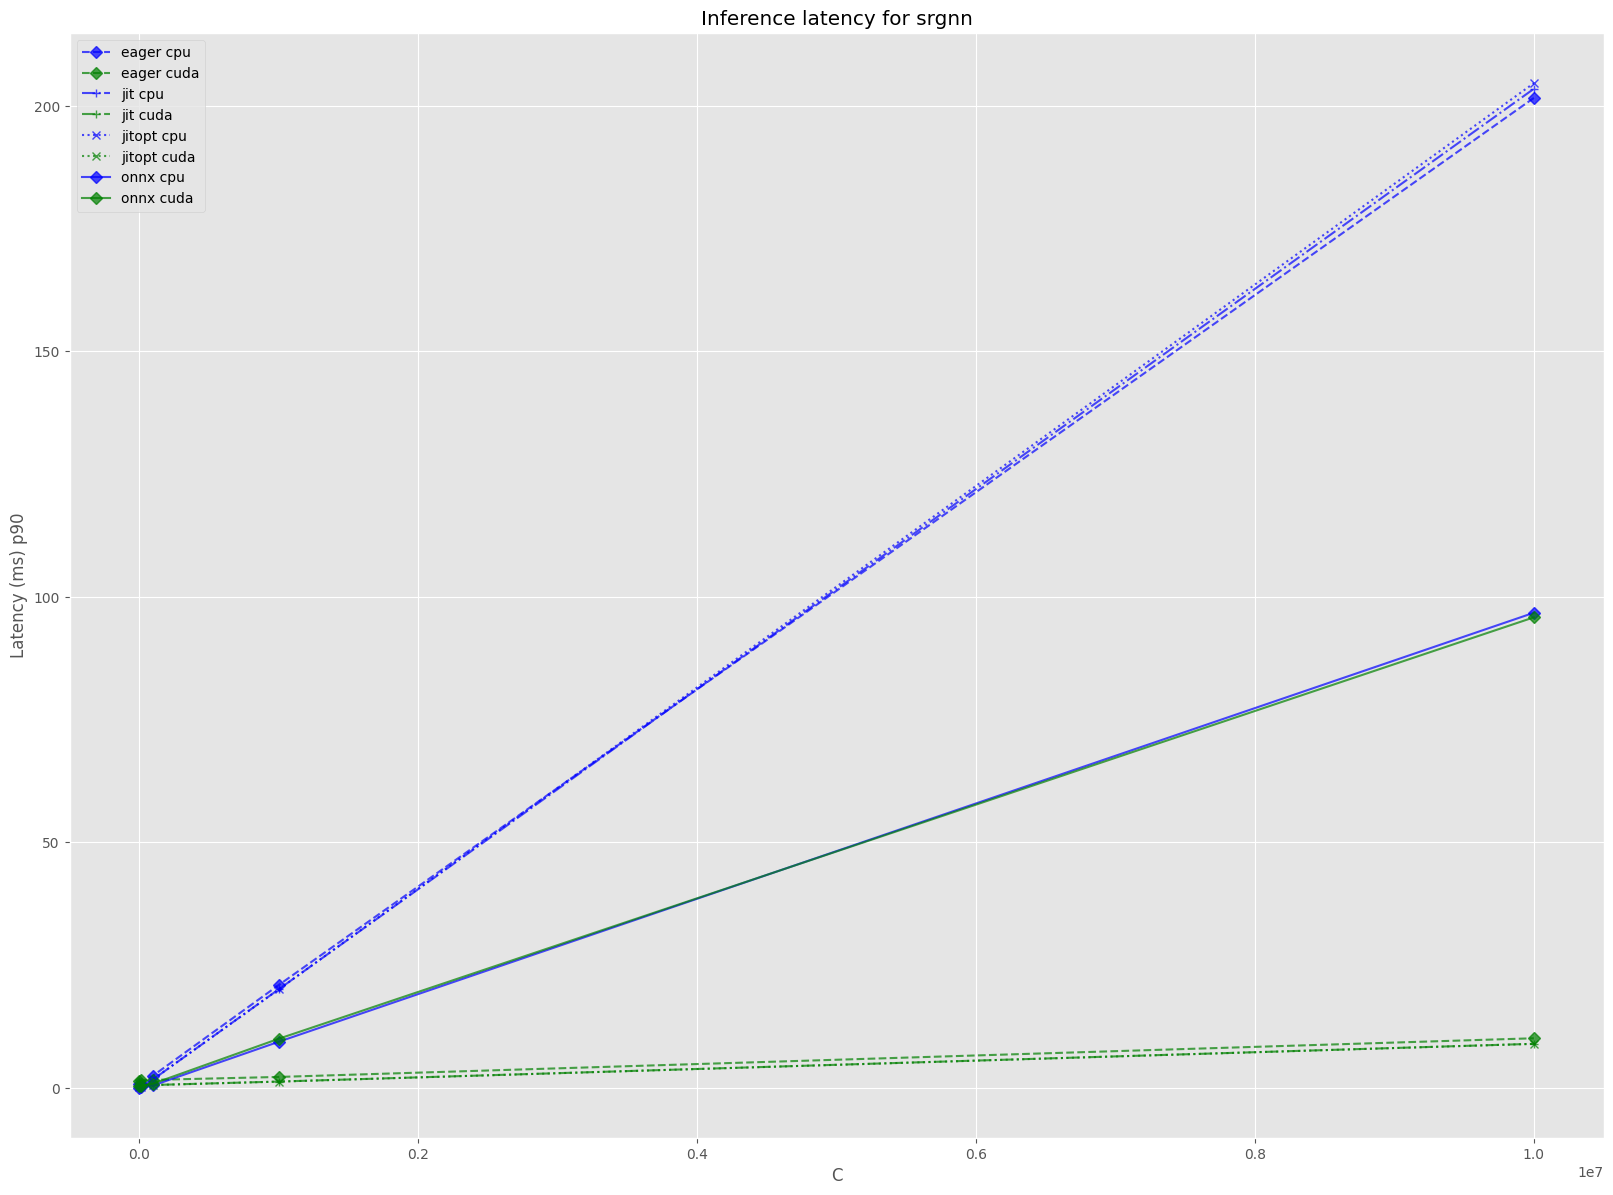

In [49]:
model_names =  ['core', 'gcsan', 'gru4rec', 'lightsans', 'narm', 'repeatnet', 'sasrec', 'sine', 'srgnn',
                        'stamp']
model_names = ['srgnn']
colors = [ 'b',  'g', 'r',  'w','c', 'm','y','k',]
markers = ['D', '+','x','D']
lss=['--','-.',':','-']
for model_name in model_names:
    runtimes = ['eager', 'jit', 'jitopt', 'onnx']
    devices = ['cpu', 'cuda']
    datasource = 'bolcom'
    fig, ax = plt.subplots(figsize=(16, 12))

    for runtime in runtimes:
        for device in devices:
            results = get_results(model_name, runtime, device, datasource)
            if len(results) > 0:
                q90s = []
                cs = []
                for C, latency_df in results.items():
                    filtered_df = latency_df[latency_df['DateTime'] >= (latency_df['DateTime'].min() + pd.Timedelta(seconds=5))]
                    # add 1 ms for log transformation
                    # filtered_df['LatencyInMs'] = filtered_df['LatencyInMs'] + 1
                    # sns.kdeplot(data = filtered_df['LatencyInMs'], cumulative = True, label = f'{C}', log_scale=False, ax=ax)
                    q90 = np.percentile(filtered_df['LatencyInMs'], q=[0.9])
                    q90s.append(q90)
                    cs.append(C)
                color = colors[devices.index(device)]
                marker = markers[runtimes.index(runtime)]
                ls = lss[runtimes.index(runtime)]
                plt.plot(cs, q90s, color=color, marker=marker, label=f'{runtime} {device}', linestyle=ls, alpha=0.7)    

    plt.title(f'Inference latency for {model_name}')
    # Get the matplotlib axis object
    ax = plt.gca()
    # Set the x-axis limits
    # ax.set_xlim([0, 20])
    # plt.axvline(x = 50, label = '50ms threshold')
    ax.legend()
    # plt.yscale('log')
    # plt.legend(title='Unique items in catalog')
    plt.tight_layout()
    plt.ylabel('Latency (ms) p90')
    plt.xlabel('C')
    plt.savefig(f'{model_name}_{datasource}.pdf', bbox_inches='tight')
    plt.show()

In [18]:
['aap', 'noot', 'mies'].index('noot')

1